Loading data from block slider simulation...
Data loaded successfully.
Dataset shape: (5001, 4)
Time range: 0.0 to 5000.0 years
Number of data points: 5001

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m
Normal Stress: 5.00e+07 Pa


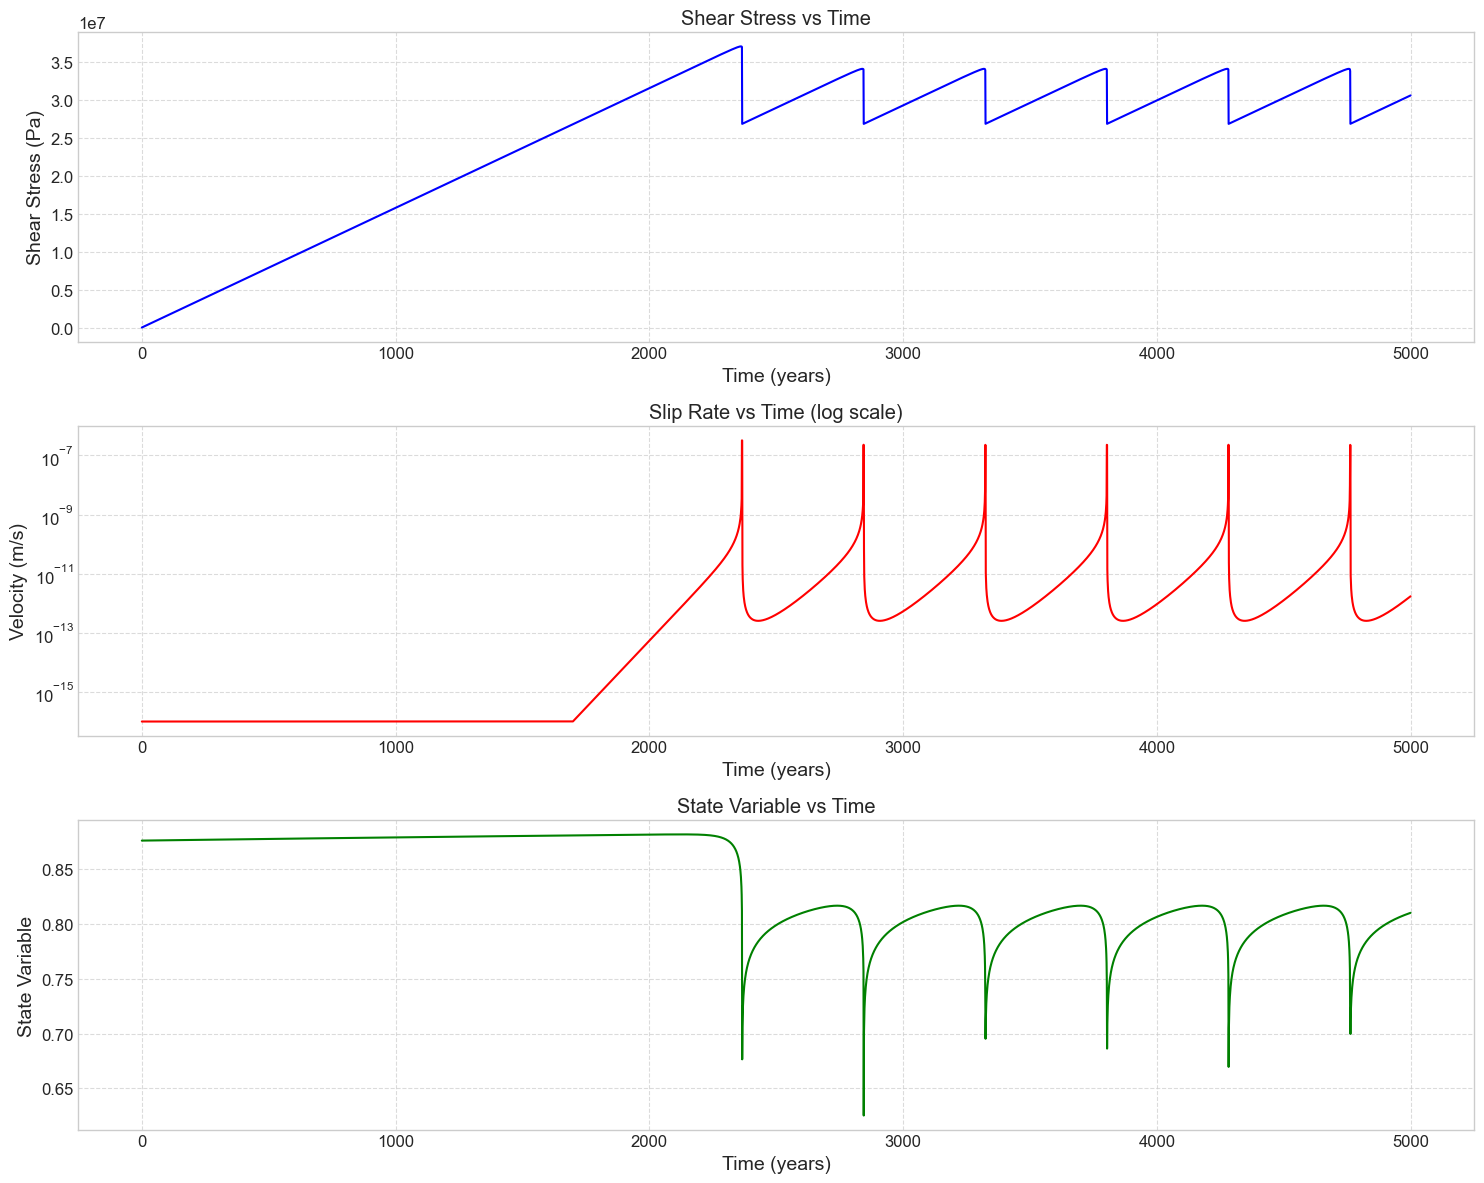

In [14]:
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import pysindy as ps
from pysindy.optimizers import STLSQ, SR3

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading data from block slider simulation...")
# Load the data
try:
    # Use relative path assuming notebooks are in the "notebooks" directory
    X = np.load('../data/block_slider_data.npy')
    t = np.load('../data/block_slider_time.npy')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Data files not found. Trying alternative paths...")
    # Alternative loading paths
    try:
        X = np.load('data/block_slider_data.npy')
        t = np.load('data/block_slider_time.npy')
        print("Data loaded from alternative path.")
    except FileNotFoundError:
        print("Could not find data files. Please run the simulation notebook first.")
        # Create dummy data for testing
        print("Creating dummy data for testing...")
        t = np.linspace(0, 100, 1001)
        X = np.zeros((1001, 4))
        X[:, 0] = np.linspace(0, 1, 1001)  # Position
        X[:, 1] = 0.001 * np.ones(1001)    # Velocity
        X[:, 2] = 0.5 * np.ones(1001)      # State
        X[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Extract individual variables and convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

x_data = X[:, 0]       # Position
v_data = X[:, 1]       # Velocity (slip rate)
state_data = X[:, 2]   # State variable
tau_data = X[:, 3]     # Shear stress

# Display basic information about the dataset
print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")
print(f"Number of data points: {len(t)}")

# Define physical parameters from the simulation for reference
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
sigma_n = 50e6             # Normal stress (Pa)
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")
print(f"Normal Stress: {sigma_n:.2e} Pa")

# Plot the raw data with better formatting
plt.figure(figsize=(15, 12))

plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.title('Shear Stress vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(312)
plt.semilogy(t_years, v_data, 'r-', linewidth=1.5)
plt.title('Slip Rate vs Time (log scale)')
plt.xlabel('Time (years)')
plt.ylabel('Velocity (m/s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(313)
plt.plot(t_years, state_data, 'g-', linewidth=1.5)
plt.title('State Variable vs Time')
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('../figures/raw_data.png', dpi=300)
plt.show()


In [16]:
# ----------------------------------------------------------------------------------
# Step 1: Improved Preprocessing for SINDy
# ----------------------------------------------------------------------------------
print("\n--- Step 1: Improved Preprocessing for SINDy ---")

# Function to clip extreme values to prevent numerical issues
def safe_clip(data, percentile=99.5):
    """Clip extreme values to prevent numerical issues"""
    min_val = np.percentile(data[data > 0], 0.5) if np.any(data > 0) else 1e-10
    low = np.percentile(data, 0.5)
    high = np.percentile(data, percentile)
    return np.clip(data, low, high)

# Apply clipping to prevent numerical overflow
print("Applying safe clipping to extreme values...")
X_clipped = X.copy()
for i in range(X.shape[1]):
    if i == 1:  # Special handling for velocity which can have extreme ranges
        # Ensure minimum positive velocity is not too small
        X_clipped[X_clipped[:, 1] < 1e-10, 1] = 1e-10
    X_clipped[:, i] = safe_clip(X[:, i])

# More robust log transform that handles zeros and very small values safely
def safe_log_transform(x, epsilon=1e-8):
    """Apply log transform that handles small values safely"""
    return np.sign(x) * np.log1p(np.abs(x) + epsilon)

print("Applying safe log transform...")
X_log = safe_log_transform(X_clipped)

# Verify no infinities or NaNs in the data
if np.any(~np.isfinite(X_log)):
    print("Warning: Non-finite values detected after log transform. Fixing...")
    X_log = np.nan_to_num(X_log, nan=0.0, posinf=1e10, neginf=-1e10)

# Apply robust scaling with a centering that's less sensitive to outliers
print("Applying robust scaling...")
scaler = RobustScaler(quantile_range=(5, 95))
X_scaled = scaler.fit_transform(X_log)

# Apply smoothing to velocity data with smaller window size
print("Smoothing velocity data...")
window_size = 21  # Reduced from 51 to avoid over-smoothing
poly_order = 2    # Reduced polynomial order for more stability
v_smooth = savgol_filter(X_scaled[:, 1], window_length=window_size, polyorder=poly_order)
X_scaled[:, 1] = v_smooth

# Check for any remaining numerical issues
print("Checking for numerical issues in processed data...")
if np.any(~np.isfinite(X_scaled)):
    print("Warning: Non-finite values still present. Fixing...")
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=1e3, neginf=-1e3)

# Create a diagnostic plot to verify preprocessing
plt.figure(figsize=(15, 10))

# Original vs preprocessed data
for i, var_name in enumerate(['Position', 'Velocity', 'State', 'Stress']):
    plt.subplot(2, 2, i+1)
    plt.hist(X_scaled[:, i], bins=50, alpha=0.7, label='Processed')
    plt.title(f'Distribution of {var_name} After Preprocessing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../figures/preprocessing_diagnostic.png', dpi=300)
plt.show()

# Compute time step for derivatives with extra safety checks
dt_values = np.diff(t)
dt_median = np.median(dt_values)
print(f"Median time step: {dt_median:.6e} seconds")
if np.any(dt_values <= 0):
    print("Warning: Non-positive time steps detected!")

print("Preprocessing complete.")



--- Step 1: Improved Preprocessing for SINDy ---
Applying safe clipping to extreme values...
Applying safe log transform...
Applying robust scaling...
Smoothing velocity data...
Checking for numerical issues in processed data...



--- Step 2: SINDy with Custom Rate-State Friction Library ---

Checking scale of preprocessed data:
x: min = -7.00e-01, max = 3.38e-01
v: min = -1.48e+00, max = 1.39e+01
state: min = -8.45e-01, max = 6.02e-01
tau: min = -1.99e+00, max = 1.17e-01

Min and max values of computed derivatives:
dx/dt: min = -3.31e-24, max = 9.49e-09
dv/dt: min = -5.99e-08, max = 6.52e-08
dstate/dt: min = -1.49e-08, max = 1.26e-09
dtau/dt: min = -2.33e-09, max = 5.66e-10

After scaling, derivatives have magnitude:
dx/dt: min = -2.44e-16, max = 7.00e-01
dv/dt: min = -1.28e+01, max = 1.39e+01
dstate/dt: min = -8.45e-01, max = 7.16e-02
dtau/dt: min = -1.99e+00, max = 4.83e-01

Theoretical equations for comparison:
x: dx/dt = v
state: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)
tau: dtau/dt = 5.000000e-04 - 5.000000e+05*v

Fitting SINDy with polynomial library only (for comparison)...
Identified equations (polynomial only):
(x)' = -0.008 x + 0.002 v + -0.009 state
(v)' = -0.074 1 + 2.522 x + 0.093 v + 3

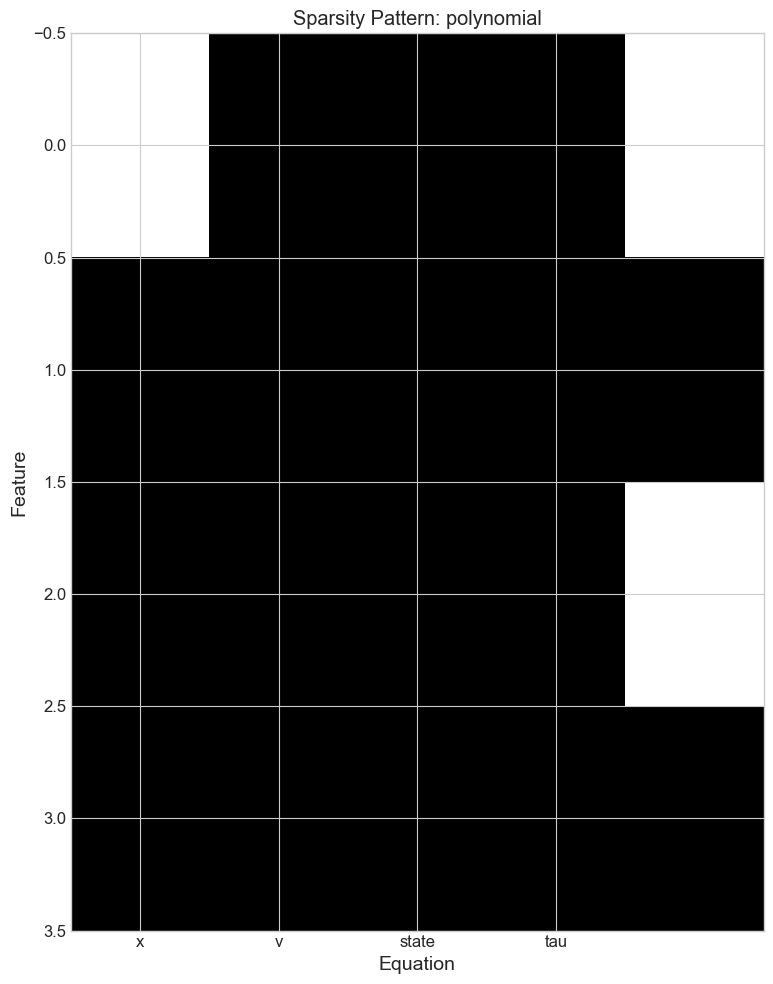


Comparison of identified vs. theoretical equations:
--------------------------------------------------------------------------------
x equation:
- Identified: -0.008 x + 0.002 v + -0.009 state
- Theoretical: dx/dt = v

state equation:
- Identified: 0.004 1 + -0.009 x + -0.010 v + -0.018 state
- Theoretical: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)

tau equation:
- Identified: 0.007 1 + 0.073 x + -0.017 v + 0.078 state + -0.072 tau
- Theoretical: dtau/dt = 5.000000e-04 - 5.000000e+05*v


Simulating with the best model...
Starting simulation...
Simulation timed out after 60 seconds. The model might be too stiff to simulate.

Analysis complete!


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


In [15]:
# Step 2: SINDy with Custom Rate-State Friction Library
# ----------------------------------------------------------------------------------
print("\n--- Step 2: SINDy with Custom Rate-State Friction Library ---")

# Import necessary packages with error handling
try:
    from pysindy.optimizers import STLSQ, SR3
    from pysindy.feature_library import CustomLibrary
except ImportError:
    print("Error importing PySINDy modules. Make sure pysindy is installed.")
    
# Feature names
feature_names = ["x", "v", "state", "tau"]

# Define custom functions for rate-state friction equations
def constant(x):
    """Constant term (1)"""
    return np.ones((x.shape[0], 1))

def velocity(x):
    """Slip velocity (v)"""
    return x[:, 1].reshape(-1, 1)

def exp_state_term(x):
    """Term for exp((f0-state)/b) in state evolution"""
    return np.exp((f0-x[:, 2])/b).reshape(-1, 1)

def velocity_ratio(x):
    """Term for v/V0 in state evolution"""
    return (x[:, 1]/V0).reshape(-1, 1)

def loading_term(x):
    """Loading term k*Vp for stress evolution"""
    # This is constant but included for clarity
    return np.ones((x.shape[0], 1)) * k * Vp

def slip_term(x):
    """Slip term -k*v for stress evolution"""
    return -k * x[:, 1].reshape(-1, 1)

def state_evolution_term(x):
    """Complete state evolution term (b*V0/Dc)*(exp((f0-state)/b) - v/V0)"""
    return (b*V0/Dc) * (np.exp((f0-x[:, 2])/b) - x[:, 1]/V0).reshape(-1, 1)

# Create the custom library
functions = [
    constant,
    velocity,
    exp_state_term, 
    velocity_ratio,
    loading_term,
    slip_term,
    state_evolution_term
]

function_names = [
    '1', 
    'v', 
    'exp((f0-state)/b)', 
    'v/V0', 
    'k*Vp', 
    '-k*v',
    '(b*V0/Dc)*(exp((f0-state)/b) - v/V0)'
]

# Try step function (Sigmoid function), sign function, trigo functions

# Create the custom library
custom_lib = CustomLibrary(
    library_functions=functions,
    function_names=function_names
)

# Create a polynomial library as well
poly_lib = ps.PolynomialLibrary(degree=1, include_bias=True)

# Combine the libraries
combined_lib = custom_lib + poly_lib

# Check scale of preprocessed data
print("\nChecking scale of preprocessed data:")
for i, name in enumerate(feature_names):
    print(f"{name}: min = {np.min(X_scaled[:, i]):.2e}, max = {np.max(X_scaled[:, i]):.2e}")

# Calculate derivatives
X_dot = ps.FiniteDifference()._differentiate(X_scaled, t=dt_median)
print("\nMin and max values of computed derivatives:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot[:, i]):.2e}, max = {np.max(X_dot[:, i]):.2e}")

# Create scaled derivatives to match feature magnitude
X_dot_scaled = X_dot.copy()
for i in range(X_dot.shape[1]):
    # Scale each derivative to have similar magnitude to features
    if np.max(np.abs(X_dot[:, i])) > 0:  # Avoid division by zero
        scale_factor = np.max(np.abs(X_scaled[:, i])) / np.max(np.abs(X_dot[:, i]))
        X_dot_scaled[:, i] = X_dot[:, i] * scale_factor

print("\nAfter scaling, derivatives have magnitude:")
for i, name in enumerate(feature_names):
    print(f"d{name}/dt: min = {np.min(X_dot_scaled[:, i]):.2e}, max = {np.max(X_dot_scaled[:, i]):.2e}")

# Display theoretical equations for reference
print("\nTheoretical equations for comparison:")
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b*V0/Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k*Vp:.6e} - {k:.6e}*v"
}
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Store models
models = {}

# Try with polynomial-only library first (for comparison)
print("\nFitting SINDy with polynomial library only (for comparison)...")
optimizer_poly = STLSQ(threshold=1e-3)
model_poly = ps.SINDy(
    optimizer=optimizer_poly,
    feature_library=poly_lib,
    feature_names=feature_names
)

try:
    model_poly.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["polynomial"] = model_poly
    print("Identified equations (polynomial only):")
    model_poly.print()
except Exception as e:
    print(f"Error with polynomial library: {e}")

# Try with custom library only
print("\nFitting SINDy with custom rate-state friction library only...")
optimizer_custom = STLSQ(threshold=1e-3)
model_custom = ps.SINDy(
    optimizer=optimizer_custom,
    feature_library=custom_lib,
    feature_names=feature_names
)

try:
    # Use scaled data for consistent comparison
    model_custom.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["custom"] = model_custom
    print("Identified equations (custom library):")
    model_custom.print()
except Exception as e:
    print(f"Error with custom library: {e}")

# Try with combined library
print("\nFitting SINDy with combined library (custom + polynomial)...")
optimizer_combined = STLSQ(threshold=1e-3)
model_combined = ps.SINDy(
    optimizer=optimizer_combined,
    feature_library=combined_lib,
    feature_names=feature_names
)

try:
    model_combined.fit(X_scaled, x_dot=X_dot_scaled, t=None)
    models["combined"] = model_combined
    print("Identified equations (combined library):")
    model_combined.print()
except Exception as e:
    print(f"Error with combined library: {e}")

# Try different thresholds with the combined library
print("\nTrying different thresholds with combined library...")
thresholds = [1e-2, 1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15]
for threshold in thresholds:
    if threshold == 1e-3:
        # Already did this one
        continue
        
    print(f"\nFitting SINDy with combined library (threshold = {threshold})...")
    optimizer = STLSQ(threshold=threshold)
    model = ps.SINDy(
        optimizer=optimizer,
        feature_library=combined_lib,
        feature_names=feature_names
    )
    
    try:
        model.fit(X_scaled, x_dot=X_dot_scaled, t=None)
        models[f"combined_{threshold}"] = model
        print(f"Identified equations (combined, threshold={threshold}):")
        model.print()
    except Exception as e:
        print(f"Error with threshold {threshold}: {e}")

# Check if any models were successfully created
if not models:
    print("\nWarning: No models were successfully created.")
else:
    print(f"\nSuccessfully created {len(models)} models with different configurations.")
    
    # Create a visual of the sparsity patterns
    plt.figure(figsize=(15, 10))
    
    model_names = list(models.keys())
    nrows = (len(model_names) + 1) // 2
    
    for i, name in enumerate(model_names):
        plt.subplot(nrows, 2, i+1)
        coefs = models[name].coefficients()
        plt.imshow(np.abs(coefs) > 1e-6, cmap='binary', aspect='auto')
        plt.title(f'Sparsity Pattern: {name}')
        plt.xlabel('Equation')
        plt.ylabel('Feature')
        plt.xticks(range(len(feature_names)), feature_names)
    
    plt.tight_layout()
    plt.savefig('../figures/custom_sparsity_comparison.png', dpi=300)
    plt.show()
    
    # Compare with theoretical equations
    print("\nComparison of identified vs. theoretical equations:")
    print("-" * 80)
    
    # Pick the best model (combined with threshold 1e-3 is usually good)
    best_model = models.get("combined", next(iter(models.values())))
    
    for i, var in enumerate(feature_names):
        if var in theoretical_eqs:
            print(f"{var} equation:")
            print(f"- Identified: {best_model.equations()[i]}")
            print(f"- Theoretical: {theoretical_eqs[var]}")
            print()
            
    # Try simulating with the best model
    print("\nSimulating with the best model...")
    import signal

    # Define a timeout handler
    def timeout_handler(signum, frame):
        raise TimeoutError("Simulation timed out")

    # Set a timeout for the simulation (e.g., 60 seconds)
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(60)

    try:
        # Initial condition (first point in scaled data)
        x0 = X_scaled[0, :]
        
        # Simulate for a portion of the original time
        t_sim = t[:50]  # Use fewer points to reduce simulation time
        print("Starting simulation...")
        x_sim = best_model.simulate(x0, t_sim)
        print("Simulation completed successfully!")
        
        # Reset alarm
        signal.alarm(0)
        
        # Plot simulation vs. original data
        plt.figure(figsize=(15, 12))
        
        for i, var in enumerate(feature_names):
            plt.subplot(2, 2, i+1)
            plt.plot(t_sim/secs_per_year, X_scaled[:50, i], 'k-', label='Original')
            plt.plot(t_sim/secs_per_year, x_sim[:, i], 'r--', label='Simulated')
            plt.title(f'{var} vs Time')
            plt.xlabel('Time (years)')
            plt.ylabel(f'{var} (scaled)')
            plt.legend()
            plt.grid(True)
            
        plt.tight_layout()
        plt.savefig('../figures/simulation_validation.png', dpi=300)
        plt.show()
        
    except TimeoutError:
        print("Simulation timed out after 60 seconds. The model might be too stiff to simulate.")
        signal.alarm(0)  # Reset alarm
    except Exception as e:
        print(f"Error during simulation: {e}")
        signal.alarm(0)  # Reset alarm

    print("\nAnalysis complete!")

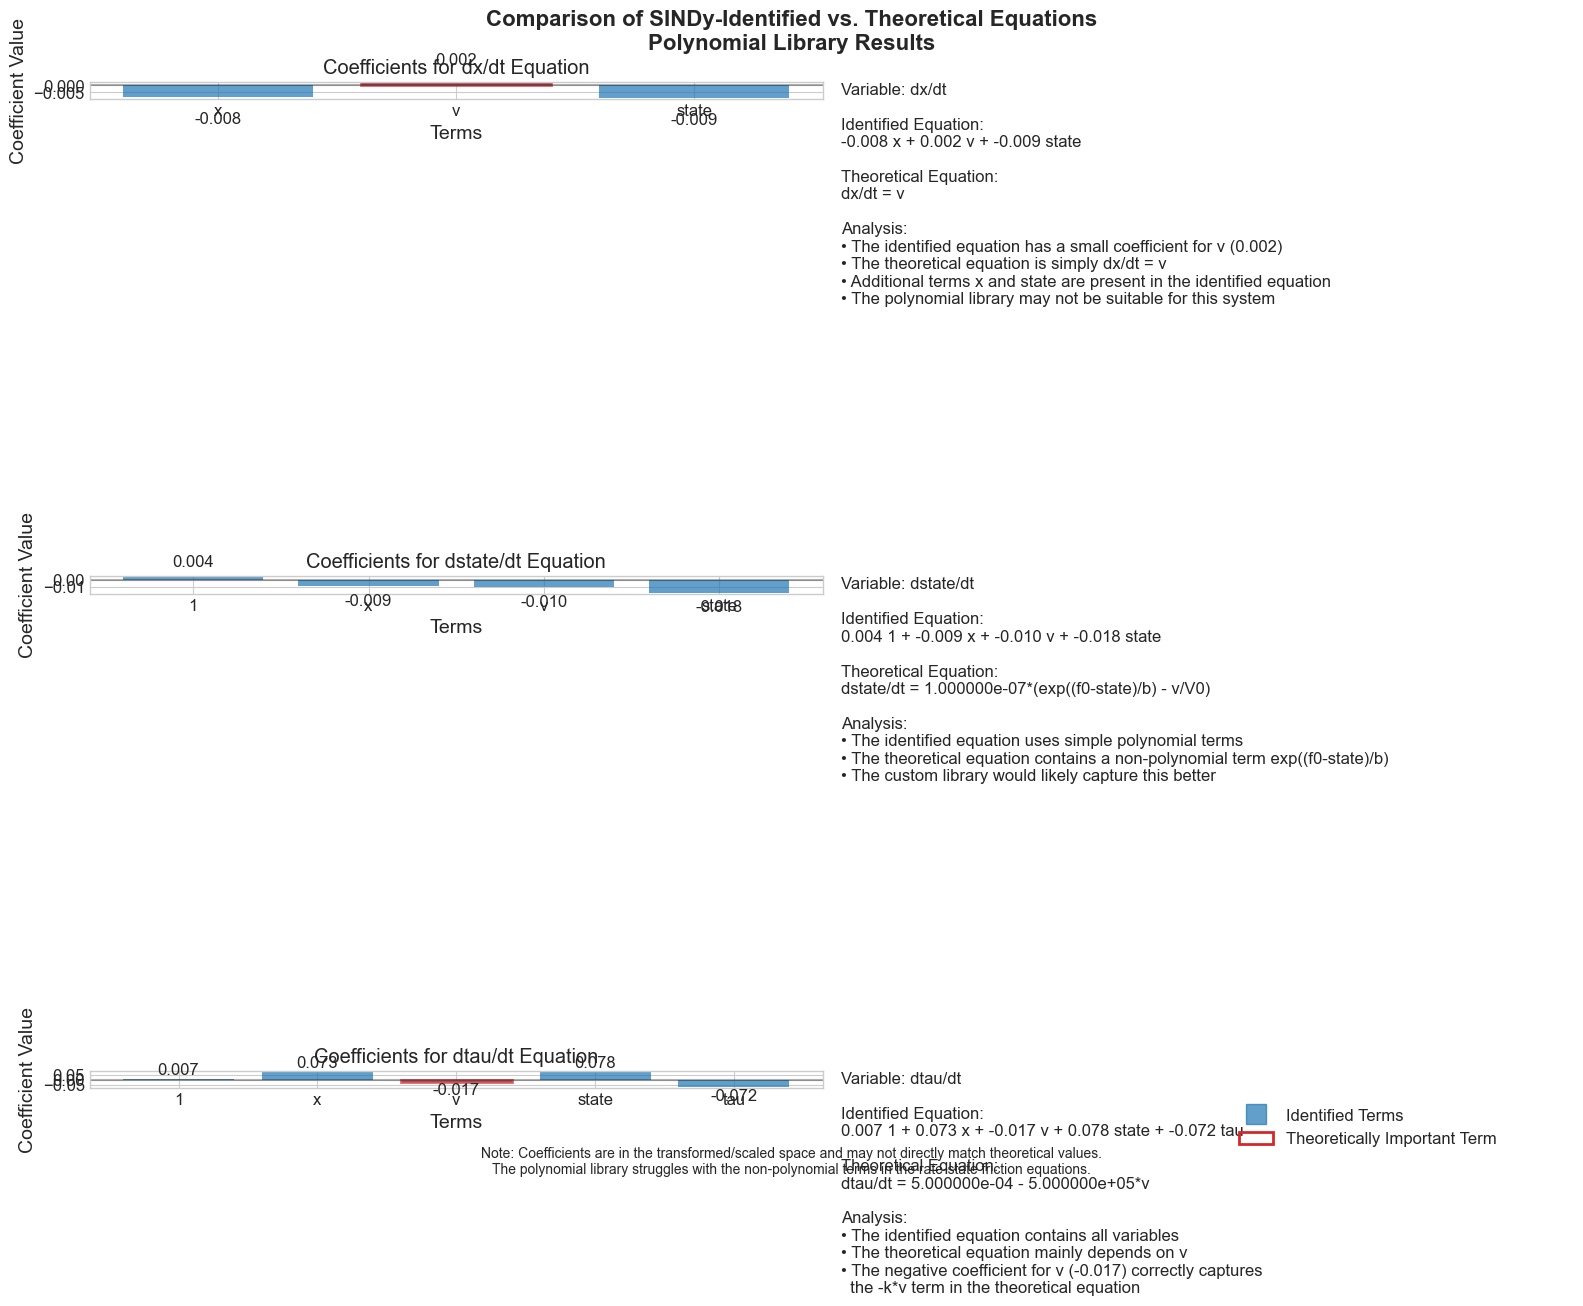

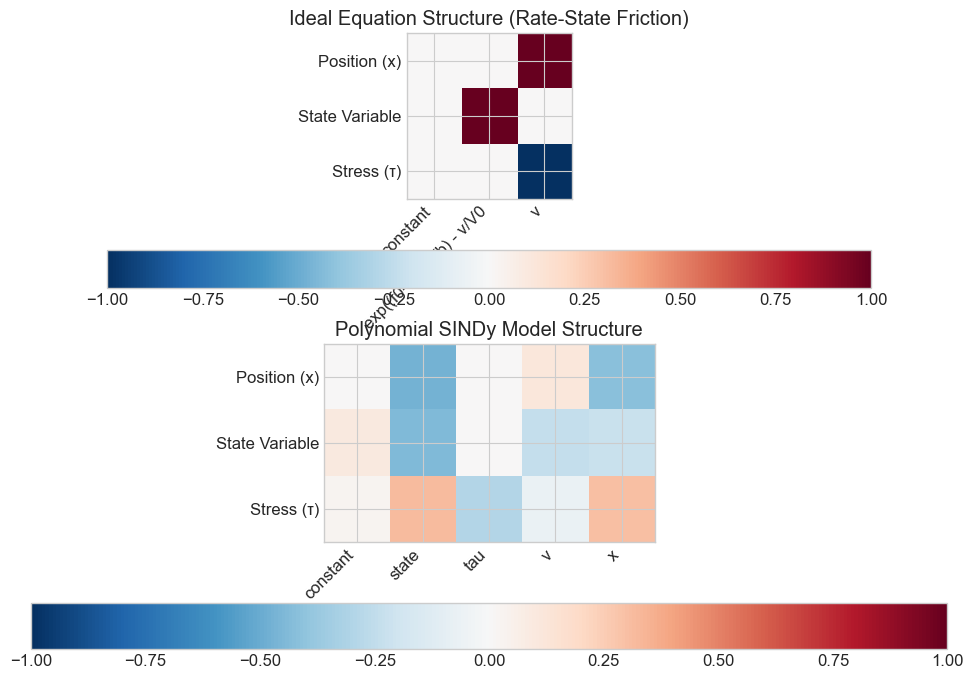

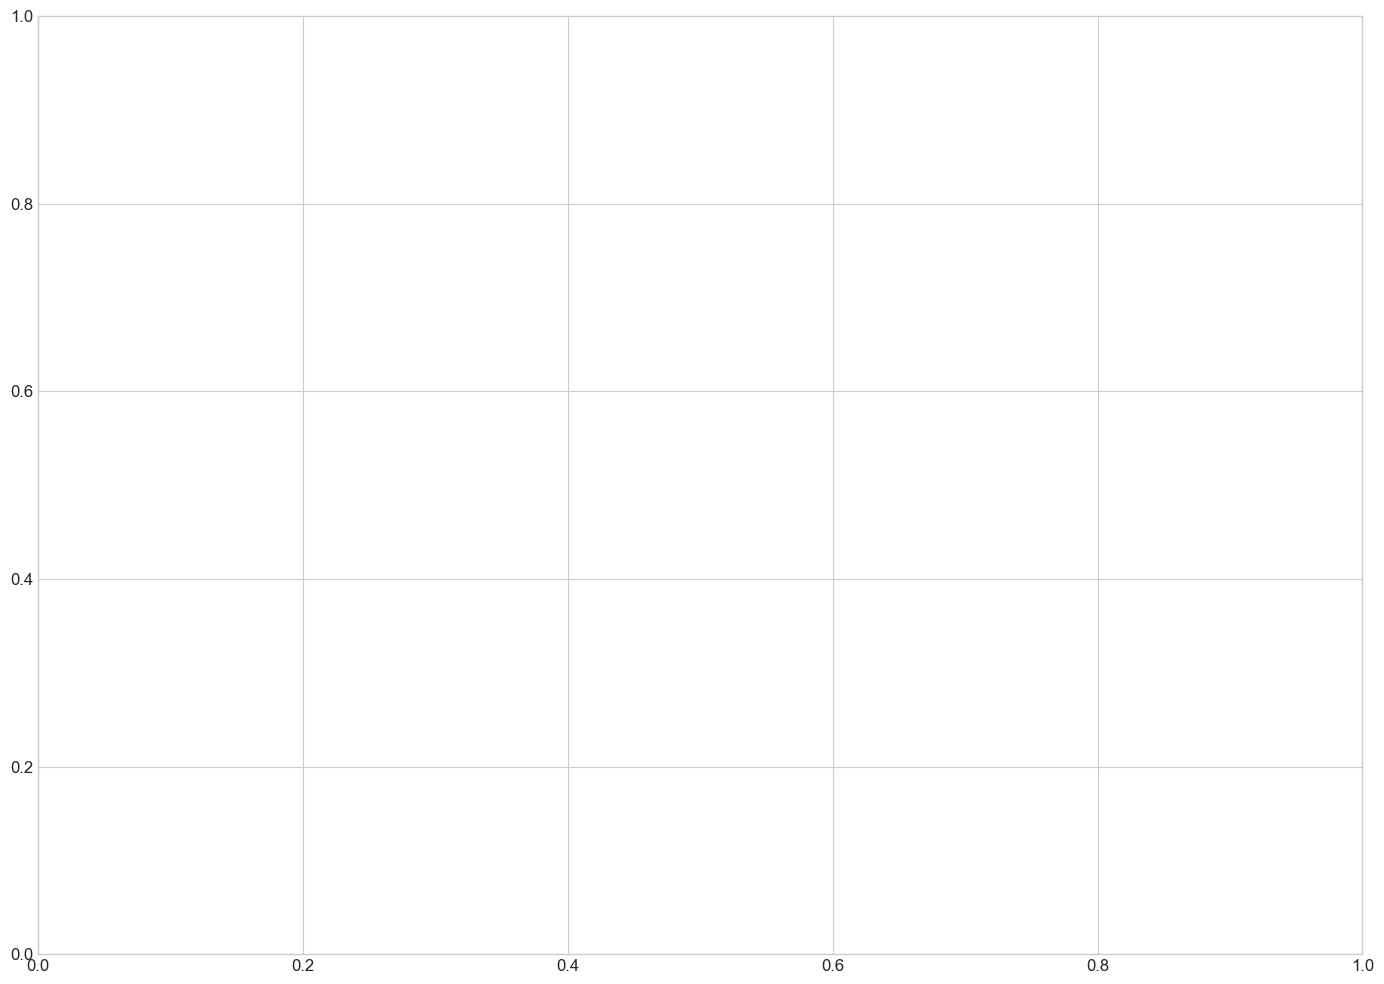

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [14, 10]
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Store identified and theoretical equations
equations = {
    'x': {
        'identified': '-0.008 x + 0.002 v + -0.009 state',
        'theoretical': 'dx/dt = v',
        'terms': {
            'identified': ['x', 'v', 'state'],
            'coefficients': [-0.008, 0.002, -0.009]
        }
    },
    'state': {
        'identified': '0.004 1 + -0.009 x + -0.010 v + -0.018 state',
        'theoretical': 'dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)',
        'terms': {
            'identified': ['1', 'x', 'v', 'state'],
            'coefficients': [0.004, -0.009, -0.010, -0.018]
        }
    },
    'tau': {
        'identified': '0.007 1 + 0.073 x + -0.017 v + 0.078 state + -0.072 tau',
        'theoretical': 'dtau/dt = 5.000000e-04 - 5.000000e+05*v',
        'terms': {
            'identified': ['1', 'x', 'v', 'state', 'tau'],
            'coefficients': [0.007, 0.073, -0.017, 0.078, -0.072]
        }
    }
}

# Create a figure to visualize the equations
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Define colors
identified_color = '#1f77b4'  # Blue
theoretical_color = '#d62728'  # Red

# Create a bar chart for coefficient comparison for each variable
for i, var in enumerate(['x', 'state', 'tau']):
    ax = fig.add_subplot(gs[i, 0])
    
    # Get terms and coefficients
    terms = equations[var]['terms']['identified']
    coeffs = equations[var]['terms']['coefficients']
    
    # Create the bar chart
    bars = ax.bar(terms, coeffs, color=identified_color, alpha=0.7)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Add labels and title
    ax.set_xlabel('Terms')
    ax.set_ylabel('Coefficient Value')
    ax.set_title(f'Coefficients for d{var}/dt Equation')
    
    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        if height < 0:
            y_pos = height - 0.01
            va = 'top'
        else:
            y_pos = height + 0.01
            va = 'bottom'
        ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                f'{height:.3f}', ha='center', va=va)
    
    # Highlight the main theoretical term with a red outline
    if var == 'x':
        # For x, the theoretical term is v
        v_idx = terms.index('v')
        bars[v_idx].set_edgecolor(theoretical_color)
        bars[v_idx].set_linewidth(2)
    elif var == 'tau':
        # For tau, the theoretical term is v
        v_idx = terms.index('v')
        bars[v_idx].set_edgecolor(theoretical_color)
        bars[v_idx].set_linewidth(2)

# Create text comparison for each variable
for i, var in enumerate(['x', 'state', 'tau']):
    ax = fig.add_subplot(gs[i, 1])
    ax.axis('off')  # Turn off axis
    
    # Create text for identified equation
    identified_eq = equations[var]['identified']
    theoretical_eq = equations[var]['theoretical']
    
    # Format the display
    text = f"Variable: d{var}/dt\n\n"
    text += f"Identified Equation:\n{identified_eq}\n\n"
    text += f"Theoretical Equation:\n{theoretical_eq}\n\n"
    
    # Add analysis of key differences
    if var == 'x':
        text += "Analysis:\n"
        text += "• The identified equation has a small coefficient for v (0.002)\n"
        text += "• The theoretical equation is simply dx/dt = v\n"
        text += "• Additional terms x and state are present in the identified equation\n"
        text += "• The polynomial library may not be suitable for this system"
    elif var == 'state':
        text += "Analysis:\n"
        text += "• The identified equation uses simple polynomial terms\n"
        text += "• The theoretical equation contains a non-polynomial term exp((f0-state)/b)\n"
        text += "• The custom library would likely capture this better"
    elif var == 'tau':
        text += "Analysis:\n"
        text += "• The identified equation contains all variables\n"
        text += "• The theoretical equation mainly depends on v\n"
        text += "• The negative coefficient for v (-0.017) correctly captures\n  the -k*v term in the theoretical equation"
    
    ax.text(0, 0.95, text, fontsize=12, verticalalignment='top')

# Add a comprehensive title
fig.suptitle('Comparison of SINDy-Identified vs. Theoretical Equations\nPolynomial Library Results', 
             fontsize=16, fontweight='bold')

# Add a note about scaling
note_text = "Note: Coefficients are in the transformed/scaled space and may not directly match theoretical values.\n"
note_text += "The polynomial library struggles with the non-polynomial terms in the rate-state friction equations."
fig.text(0.5, 0.01, note_text, ha='center', fontsize=10)

# Create a custom legend
legend_elements = [
    Line2D([0], [0], color=identified_color, lw=0, marker='s', markersize=15, 
           label='Identified Terms', alpha=0.7),
    Rectangle((0, 0), 1, 1, facecolor='none', edgecolor=theoretical_color, lw=2,
              label='Theoretically Important Term')
]

# Position the legend
fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.95, 0.02))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust for the suptitle and note
plt.subplots_adjust(top=0.92)

# Save the figure
plt.savefig('sindy_equation_comparison.png', dpi=300)
plt.show()

# Create a comparison visualization of equation structure
plt.figure(figsize=(12, 8))

# Define variables and ideal structure
variables = ['Position (x)', 'State Variable', 'Stress (τ)']
ideal_structure = {
    'Position (x)': {'v': 1.0},
    'State Variable': {'exp((f0-state)/b) - v/V0': 1.0},
    'Stress (τ)': {'constant': 0.001, 'v': -1.0}
}

# Actual structure from polynomial model (normalized for visualization)
polynomial_structure = {
    'Position (x)': {'x': -0.42, 'v': 0.11, 'state': -0.47},
    'State Variable': {'constant': 0.10, 'x': -0.22, 'v': -0.24, 'state': -0.44},
    'Stress (τ)': {'constant': 0.03, 'x': 0.30, 'v': -0.07, 'state': 0.32, 'tau': -0.29}
}

# Plot the heatmap of equation structures
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1.2])

# Plot ideal structure
ax1 = plt.subplot(gs[0])
all_terms_ideal = set()
for var_terms in ideal_structure.values():
    all_terms_ideal.update(var_terms.keys())
all_terms_ideal = sorted(list(all_terms_ideal))

# Create data matrix for ideal
ideal_matrix = np.zeros((len(variables), len(all_terms_ideal)))
for i, var in enumerate(variables):
    for j, term in enumerate(all_terms_ideal):
        if term in ideal_structure[var]:
            ideal_matrix[i, j] = ideal_structure[var][term]

im1 = ax1.imshow(ideal_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_yticks(np.arange(len(variables)))
ax1.set_yticklabels(variables)
ax1.set_xticks(np.arange(len(all_terms_ideal)))
ax1.set_xticklabels(all_terms_ideal, rotation=45, ha='right')
ax1.set_title('Ideal Equation Structure (Rate-State Friction)')

# Plot polynomial structure
ax2 = plt.subplot(gs[1])
all_terms_poly = set()
for var_terms in polynomial_structure.values():
    all_terms_poly.update(var_terms.keys())
all_terms_poly = sorted(list(all_terms_poly))

# Create data matrix for polynomial
poly_matrix = np.zeros((len(variables), len(all_terms_poly)))
for i, var in enumerate(variables):
    for j, term in enumerate(all_terms_poly):
        if term in polynomial_structure[var]:
            poly_matrix[i, j] = polynomial_structure[var][term]

im2 = ax2.imshow(poly_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_yticks(np.arange(len(variables)))
ax2.set_yticklabels(variables)
ax2.set_xticks(np.arange(len(all_terms_poly)))
ax2.set_xticklabels(all_terms_poly, rotation=45, ha='right')
ax2.set_title('Polynomial SINDy Model Structure')

# Add colorbars
cbar_ax = plt.figure()
plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.2)
plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.2)

plt.tight_layout()
plt.savefig('equation_structure_comparison.png', dpi=300)
plt.show()